<a href="https://colab.research.google.com/github/somosnlp/nlp-de-cero-a-cien/blob/main/2_modelos_secuenciales/LSTM_NLP_clasificador_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

Notebook original creado por David Llorente @Narrativa.

## Descargamos el dataset

In [2]:
!wget https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

--2025-06-11 06:38:08--  https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.09s   

2025-06-11 06:38:09 (51.4 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



## Importamos las librerías requeridas

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

2.18.0


## Visualizamos el dataset

In [5]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
df.category.value_counts()

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


## Creamos el dataset

In [8]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:

  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    labels.append(row[0])
    article = row[1]

    for word in STOPWORDS:
      token = ' ' + word + ' '
      article = article.replace(token, ' ')
      article = article.replace('  ', ' ')
    articles.append(article)

print(len(labels))
print(len(articles))

2225
2225


## Definimos algunos parámetros de la red

In [9]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

## Dividimos del dataset

In [10]:
train_size = int(len(articles) * training_portion)
print(train_size)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Creamos el Tokenizador

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)

word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2432, 1, 225, 4997, 22, 641, 586, 225, 4997, 1, 1, 1663, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1145, 1695, 1, 1722, 4998, 1, 1, 1, 1, 1, 4739, 1, 1, 122, 4516, 1, 2, 2876, 1506, 352, 4740, 1, 52, 341, 1, 352, 2173, 3962, 41, 22, 3796, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4741, 1, 365, 22, 1, 787, 2368, 1, 4304, 138, 10, 1, 3667, 682, 3532, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4997, 1, 600, 1, 1695, 1022, 1, 4999, 807, 1865, 117, 1, 1, 1, 2976, 22, 1, 99, 278, 1, 1608, 1, 542, 492, 1, 1444, 4742, 778, 1321, 1, 1862, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1507, 22, 479, 1, 1, 1666, 1, 797, 1, 3068, 1, 1365, 6, 1, 2432, 564, 22, 2973, 4736, 1, 1, 1, 1, 1, 850, 39, 1826, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1097, 4305, 247]


In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]), len(train_padded[0]))
print(len(train_sequences[1]), len(train_padded[1]))
print(len(train_sequences[10]), len(train_padded[10]))

426 200
192 200
186 200


In [14]:
print(train_padded[10])

[2432    1  225 4997   22  641  586  225 4997    1    1 1663    1    1
 2432   22  564    1    1  140  278    1  140  278  796  823  662 2308
    1 1145 1695    1 1722 4998    1    1    1    1    1 4739    1    1
  122 4516    1    2 2876 1506  352 4740    1   52  341    1  352 2173
 3962   41   22 3796    1    1    1    1  542    1    1    1  835  631
 2367  347 4741    1  365   22    1  787 2368    1 4304  138   10    1
 3667  682 3532    1   22    1  414  823  662    1   90   13  633    1
  225 4997    1  600    1 1695 1022    1 4999  807 1865  117    1    1
    1 2976   22    1   99  278    1 1608    1  542  492    1 1444 4742
  778 1321    1 1862   10   33  641  319    1   62  478  564  301 1507
   22  479    1    1 1666    1  797    1 3068    1 1365    6    1 2432
  564   22 2973 4736    1    1    1    1    1  850   39 1826  675  297
   26  979    1  882   22  361   22   13  301 1507 1343  374   20   63
  883 1097 4305  247    0    0    0    0    0    0    0    0    0    0
    0 

In [15]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


## Codificamos las etiquetas usando el Tokenizador



In [16]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest <OOV> trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film enti

## Construimos nuestra red neuronal

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  tf.keras.layers.Dense(embedding_dim, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [22]:
num_epochs = 3
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/3
56/56 - 10s - 180ms/step - accuracy: 0.2815 - loss: 1.5954 - val_accuracy: 0.4584 - val_loss: 1.4291
Epoch 2/3
56/56 - 9s - 163ms/step - accuracy: 0.5011 - loss: 1.2051 - val_accuracy: 0.6787 - val_loss: 0.8027
Epoch 3/3
56/56 - 7s - 122ms/step - accuracy: 0.8534 - loss: 0.4545 - val_accuracy: 0.8697 - val_loss: 0.3562


## Visualizamos los resultados

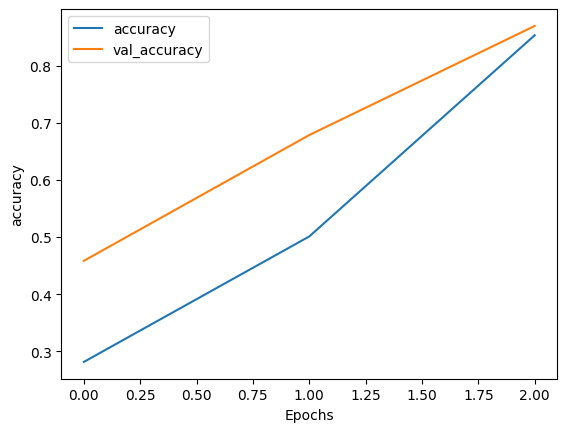

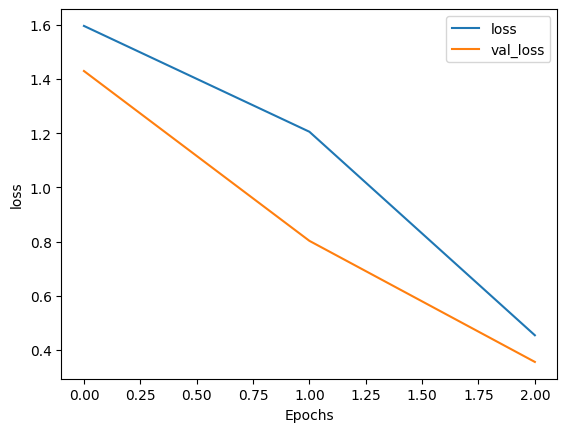

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [25]:
import pprint

txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)

pred = model.predict(padded)
print('Predicción\n')

pprint.pprint(pred)
print()

labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(txt[0] + ' ==> ' + labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicción

array([[0.20612858, 0.07385057, 0.09361871, 0.15499446, 0.2578036 ,
        0.21360403]], dtype=float32)

Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report. ==> entertainment
